<a href="https://colab.research.google.com/github/CharlieOlives/MAI/blob/main/linguistics_ai_exerciseSession1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linguistics and artificial intelligence: practical session 1 (10 October 2023)

## Machine learning for NLP


Note: you are not required to submit any assignments for this practical session.

In this practical session, you will carry out a number of programming
exercises on machine learning for NLP, using Python. It will be helpful if you already know some basic Python (as provided in the first lectures of the course 'Scripting Languages', for example). But even you don't know anything about programming, you should be able to follow along with the examples.

For these exercises, we will make use of the interactive Python environment provided by Google Colab. The environment makes it possible to run Python code within your web browser. As an example, the code below computes the result of a sum, and outputs the result. Run the code by hovering over it, and pressing the play button in front.



In [ ]:
result = 2 + 2
print(result)

### Introduction

In this practical session, we will explore machine learning models for
NLP applications; specifically, we will train statistical and neural network classifiers for
sentiment analysis on an English dataset of movie reviews (Maas et al., 2011).

First, download the archive that contains the dataset and unpack it, using the commands below:

In [ ]:
!wget http://www.ccl.kuleuven.be/Courses/linguistics_and_ai/data/review_dataset.tar.gz
!tar xzvf review_dataset.tar.gz

A traditional machine learning pipeline for NLP applications generally consists of the following stages:

* data preprocessing (tokenization)
* feature extraction
* model training
* evaluation


We'll go through these stages step by step, using sentiment
classification as an application. As a dataset, we'll be using a set
of movie reviews in English, extracted from the website
[imdb.com](https://www.imdb.com). The dataset consists of the text of the review, as
well as a sentiment label (positive or negative). Note that
  the original ratings on IMDB range from 0 to 10
  stars. We will use binary classification instead. In our dataset,
  original reviews of $\leq 4$ stars are considered negative, while
  reviews of $\geq 7$ stars are considered positive. The training set is
divided into a training part (for training, 20000 reviews, i.e. 80%) and
test part (for evaluation, 5000 reviews, i.e. 20%). The dataset is
balanced, which means positive and negative instances are evenly
distributed in both train and test set.

### Preprocessing

First, we'll load the training set. To do so, we'll make use of the `pandas` library, which facilitates data manipulation. Issue the commands below:

In [ ]:
import pandas as pd
train = pd.read_csv('reviews_train.csv', header=0, delimiter='\t', quoting=3)

We can now examine the data. Explore the dataset using the commands below. Note that negative sentiment is denoted by `0` and positive sentiment by `1`.


In [ ]:
train.head()

In [ ]:
print(train['review'][0])

Generally, we need to preprocess the dataset to be able to properly extract features from it. Within a computer, text is encoded as a continuous string of characters. For a computer, there is no difference between a space, a punctuation mark, or an alpha-numeric character. This means that a computer does not know about word or sentence boundaries. In order to analyze textual data within natural language processing applications, we first need to properly preprocess it. Note that our data has already been tokenized (i.e. words have been properly segmented), so we don't need to preprocess our data anymore.


### Feature extraction

Now it’s time to decide which features to use in our classifier. We’ll start with simple bag of words features. For this, we can make use of `scikit-learn`'s `CountTokenizer` object. `scikit-learn` (the model name of which is `sklearn`) is a well known Python library that implements a wide range of machine learning algorithms. `CountVectorizer` is part of `scikit-learn`'s feature extraction toolkit; it allows us to convert a collection of documents to a matrix of token counts (one feature vector for each review). We define the parameter `max_features` to be 500, which means only the 500 most frequent words will be taken into account. Once we have defined the `CountVectorizer` object, we can perform the actual feature extraction using the function `fit_transform`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', max_features = 500)
train_data_features = vectorizer.fit_transform(train['review'])

# train_data_features is a big vector containing for each review, the amount of times a certain word is present. The words are represented as numbers, which the CountVectorizer did.

# With fit_transform, you match the occurence of each word to the sentiment? vb, if a negative sentiment is linked to the word 'terrible' occurring 10 times, then terrible is probably a negative word.

Using the command below, we can inspect the shape of the resulting matrix:

In [ ]:
print(train_data_features.shape)

The output above tells us that we have a matrix of 20000 documents (reviews), by 500 word features. Each matrix cell represents the frequency of each of the 500 words within a particular review.

We can also inspect which are the 500 most frequent words that are used as features, using the command below:

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(vocab)

### Classification

`scikit-learn` contains many different implementations of classification algorithms. We’ll start with the classifier we examined during the lectures: a naive Bayes classifier. The naive Bayes classifier is represented by the `MultinomialNB` class. Once we have instantiated it, we can train it on our data using the `fit` function. Note that we are providing to the function both the features extracted for each review (`train_data_features`) and the correct sentiment label (`train['sentiment']`) for each review. In the training step, we need to provide our model with the correct answer.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

classifier.fit(train_data_features, train['sentiment'])

Our model has now been trained on the training set; we can now test its performance on the test set. First, we carry out the same preprocessing and feature extraction on the test set.

In [ ]:
test = pd.read_csv('reviews_test.csv', header=0, delimiter='\t', quoting=3)
test_data_features = vectorizer.transform(test['review'])

Next, we can compute the performance on the test set.

In [ ]:
score = classifier.score(test_data_features, test['sentiment'])
print(score)

#### Exercise 1



1.   What does the score represent?
2.   Look at the instances that were classified badly. Do you see why certain reviews are misclassified? Hint: use the function `predict`.



In [ ]:
## The score represents the average accuracy of the model in predicting sentiment on new data.

# The predict function (on the fitted model) gives the predicted sentiment of each review in the input data.
predicted = classifier.predict(test_data_features)
# Compare performance on test set with the actual sentiments:
sentiments = train['sentiment']
comparison = predicted - sentiments[len(predicted)]

### VERBETERING ###

import numpy as np
predictions = classifier.predict(test_data_features)

np.where(predictions != test['sentiment']) # check where predicted and correct ones differ
test['review'][3]



### K-fold cross validation

Usually, we will want to try out different parameters, in order to see what works best for our task. As such, we might experiment with:


* Different features
* Different classification algorithms
* Different model parameters


However, we have to be careful: we cannot use our test set over and over again, as we'll be optimizing our parameters for that particular test set (and run the risk of overfitting, which means we are not able to properly generalize to data we haven't trained on). For this reason, we need to make use of a **validation set**. However, our training set is already quite small; creating a separate validation set would give us even less training data. Fortunately, we don't have to create a separate set: we can use **k-fold cross validation**. The idea is the following:

* Break up data into $k$ (e.g. 10) parts (folds)
* For each fold

    * Current fold is used as temporary test set (called **validation** set)
    * Use other 9 folds as training data
    * Performance is computed on test fold

*  Average performance over 10 runs

A graphical representation of 10-fold cross validation is given below:


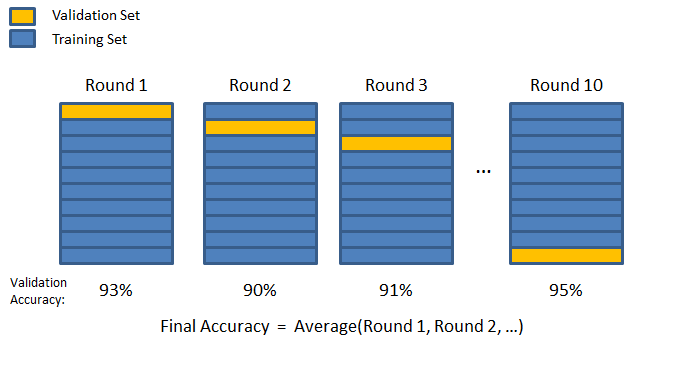

K-fold cross validation is implemented in the `StratifiedKFold` class. 'Stratified' means that we keep the number of positive and negative instances in the train and test set balanced throughout the cross-validation steps.

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10) # partition the sentiments equally over all folds.
score_kfold = []

# what the loop does: we have the folds, and want to train data on each one.
for n_fold, (train_indices, test_indices) in enumerate(kf.split(train_data_features, train['sentiment'])):
    X_train, X_test = train_data_features[train_indices], train_data_features[test_indices]
    y_train, y_test = train['sentiment'][train_indices], train['sentiment'][test_indices]

    classifier.fit(X_train, y_train)
    print('Score on fold' , n_fold, ':', classifier.score(X_test, y_test))
    score_kfold.append(classifier.score(X_test, y_test))

print('Average performance: ', sum(score_kfold) / len(score_kfold))

#### Exercise 2

* Experiment with different feature sets
    * Experiment with n-grams instead of bag of words (hint: look at the arguments of CountVectorizer again in order to extract n-grams)

    * Change the number of vocabulary elements included in the model

* Experiment with different models

    * Try [a naive bayes classifier that uses binary features](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) (word presence
instead of word count)
    * Try [any other classifier included with scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) (e.g. [decision trees](https://scikit-learn.org/stable/modules/tree.html), or [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)) How does it perform?

* When you’ve determined the best set of parameters (according to cross-validation), compute the performance on the test set

In [ ]:
######## Experiment with different feature sets ############

### feature extraction ###
from sklearn.feature_extraction.text import CountVectorizer

# We now tell the CountVectorizer to not count words, but n-grams: these are sequences of n tokens (in this case words?) from the dataset.
# For instance, one token may be 'the big', another 'big cat'. This way, it is easier for the model to spot words that are often placed consequentially?
vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(2,3), max_features = 1000)
train_data_features = vectorizer.fit_transform(train['review'])

### classification ###

### wrong: did not do k fold validation. See correction.

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

classifier.fit(train_data_features, train['sentiment'])

### training: preparing test set ###

test = pd.read_csv('reviews_test.csv', header=0, delimiter='\t', quoting=3)
test_data_features = vectorizer.transform(test['review'])

### testing accuracy of model ###

score = classifier.score(test_data_features, test['sentiment'])
print(score)

# After playing around with the # of n-grams and # of features, I find:
        # the higher the # of features (>1000), the higher the accuracy.
        # the lower the length of n-grams (1,2), the higher the accuracy.




In [ ]:
######## Experiment with different models ############
#### naive Bayes binary classifier ####
from sklearn.naive_bayes import BernoulliNB

### feature selection ###
vectorizer2 = CountVectorizer(binary= True) # This time, we create binary features: if the word is present or not.
train_data_features2 = vectorizer2.fit_transform(train['review'])

### classification ###
classifier2 = BernoulliNB()
sentiments = train['sentiment']
classifier2.fit(train_data_features2, sentiments)

### Training ###
test = pd.read_csv('reviews_test.csv', header=0, delimiter='\t', quoting=3)
test_data_features = vectorizer.transform(test['review'])

### Testing accuracy of model ###
score = classifier2.score(test_data_features, test['sentiment'])
print(score)


In [ ]:
######## Experiment with different models ############
#### other classifier (decision tree or logistic regression for instance) ####
from sklearn


### conclusion: logistic regression is best out of all models.


### Intrinsic model evaluation

Some models allow us to look at the most informative features. Using a logistic
regression, you can do the following:

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_data_features, train['sentiment'])

allCoefficients = [(classifier.coef_[0,i], vocab[i]) for i in range(len(vocab))]

allCoefficients.sort()
allCoefficients.reverse()

#### Exercise 3

Examine the top and the bottom features of the `allCoefficients` list. Which features are the most informative?

In [ ]:
###your code here

print(allCoefficients[0:10])
print(allCoefficients[-10:-1])

### References

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. 2011. Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).